# Clustering tutorial 

In [1]:
from capymoa.base import MOAClusterer
from capymoa.stream.generator import RandomRBFGeneratorDrift
from moa.clusterers.clustream import Clustream
from capymoa.evaluation.visualization import plot_clustering_state

## 1. Getting started example

- Here we use only a stream and a clusterer
- We implement the loop manually
- We use a visualization function to print the clustering state

In [2]:
stream = RandomRBFGeneratorDrift(number_of_attributes=2, number_of_centroids=10, number_of_drifting_centroids=1, magnitude_of_change=0.001)
clustream = MOAClusterer(schema=stream.get_schema(), moa_learner=Clustream, CLI="-k 10")

Processed 100 instances.


/Users/gwcassales/Documents/CapyMOA/src/capymoa/evaluation/visualization.py:839: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Processed 200 instances.
Processed 300 instances.


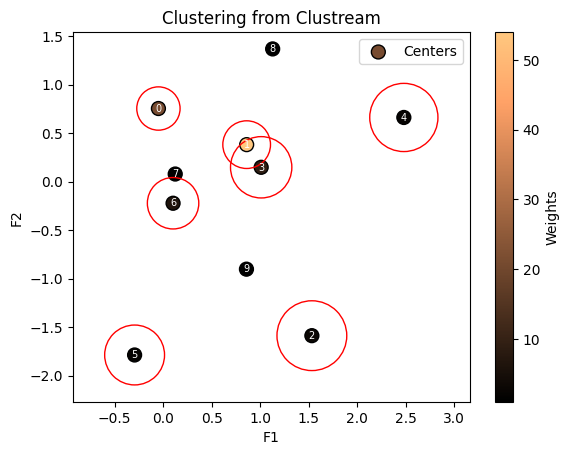

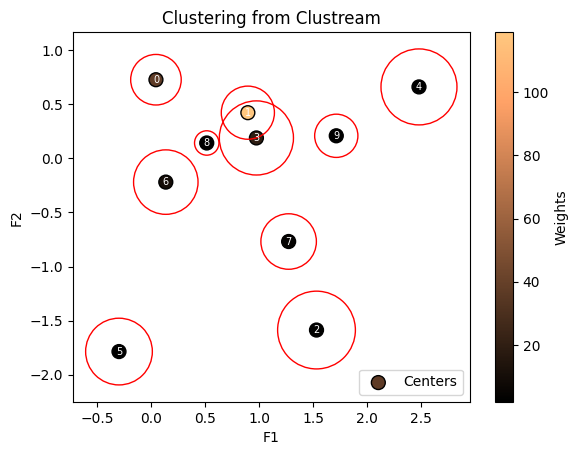

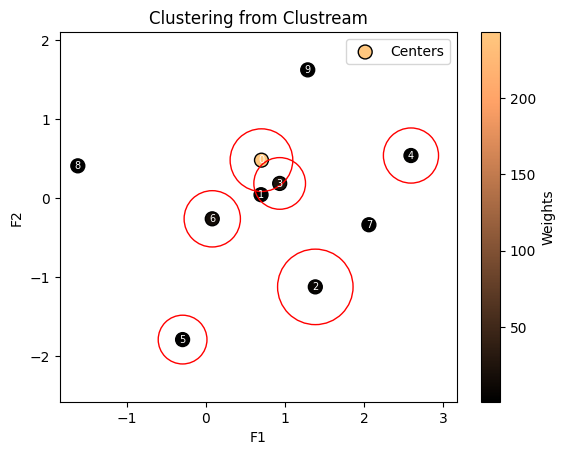

In [3]:
instancesSeen = 0
updateInterval = 100
while stream.has_more_instances() and instancesSeen < 300:
    instance = stream.next_instance()
    clustream.train(instance)
    instancesSeen += 1
    if instancesSeen % updateInterval == 0:
        print(f"Processed {instancesSeen} instances.")
        plot_clustering_state(clustream)
        # by default, plot_clustering_state only shows the image and does not save it

## 2. Using the Clustering Evaluator


In [4]:
from capymoa.evaluation import ClusteringEvaluator

In [5]:
stream = RandomRBFGeneratorDrift(number_of_attributes=2, number_of_centroids=10, number_of_drifting_centroids=1, magnitude_of_change=0.001)
clustream = MOAClusterer(schema=stream.get_schema(), moa_learner=Clustream, CLI="-k 10")
evaluator = ClusteringEvaluator(update_interval=50)

### 2.1 It is still possible to plot the clustering state of a clusterer on demand

In [6]:
while stream.has_more_instances() and evaluator.get_instances_seen() < 1000:
    instance = stream.next_instance()
    clustream.train(instance)
    evaluator.update(clustream)
    instancesSeen = evaluator.get_instances_seen()
    # purposefully arbitrary number
    if instancesSeen == 157:
        # can also skip show and only save
        print(f"Processed {instancesSeen} instances. Saving the figure without showing it.")
        plot_clustering_state(clustream, show_fig=False, save_fig=True, figure_name='save_fig_dont_show')


Processed 157 instances. Saving the figure without showing it.


### 2.2 Alternatively,  it is possible to plot the evaluation results as a whole, generating a gif

- Passing `clean_up=False` to the `plot_clustering_evolution` function will keep the intermediate figures used to create the gif.


In [7]:
from capymoa.evaluation.visualization import plot_clustering_evolution
plot_clustering_evolution(evaluator, clean_up=True)